<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/metalens_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


This may take a minute or two so be patient! We are working to optimize repository size and structure. 

In [12]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

Updated git hooks.
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 2093, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 2093 (delta 57), reused 55 (delta 42), pack-reused 1981
Receiving objects: 100% (2093/2093), 482.35 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (637/637), done.
Checking out files: 100% (961/961), done.
Filtering content: 100% (25/25), 526.67 MiB | 25.65 MiB/s, done.


In [13]:
%cd /content/DFlat/DFlat
!python setup.py develop

/content/DFlat/DFlat


In [15]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Create a general optimization pipeline using the psf layer and the neural optical model 

A general pipeline class can be reused for different settings (e.g. neural models) or loss functions as defined in the next section! This is why we structure the software flow like this! 

We first import the dflat modules which include packaged routines that are compatible with the tf.keras framework


In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

import dflat.optimization_helpers as df_optimizer
import dflat.fourier_layer as df_fourier
import dflat.neural_optical_layer as df_neural
import dflat.physical_optical_layer as df_physical
import dflat.data_structure as df_struct
import dflat.tools as df_tools


We first build an optimization class inheriting from the df_optimizer.Pipeline_Object (although you can choose to not use this).

By inheriting this class, all the details of saving and loading custom model checkpoints are taken care of. Moreover, this class allows us to use convenient, pre-written functions for training loops, enabling faster prototyping.  

Most of the lines below are used to define the visualizeTrainingCheckpoint. This is a plotting functions that will be called during save checkpoints (intermediary epochs) to monitor the process when using the training helpers in the df_optimizer module! Defining this function overides the parent empy function and is entirely optional! If not included, no visualization plots will be made but the code will still run.

In the collab, these plots wont actually save since no google drive or harddrive is mounted but that is okay! we can always view plots manually at the end by tweaking the code and calling the function with plt.show()

In [26]:
class pipeline_Metalens_MLP(df_optimizer.Pipeline_Object):

    def __init__(self, propagation_parameters, point_source_locs, savepath, saveAtEpochs=None):
        super(pipeline_Metalens_MLP, self).__init__(savepath, saveAtEpochs)

        self.propagation_parameters = propagation_parameters
        self.point_source_locs = point_source_locs

        # define computational layers
        mlp_model = "MLP_Nanocylinders_Dense64_U180_H600"
        self.mlp_latent_layer = df_neural.MLP_Latent_Layer(mlp_model, dtype=tf.float64)
        self.psf_layer = df_fourier.PSF_Layer_Mono(propagation_parameters)
        # broadband psf layer can be used instead. This will be shown in another 
        # example script

        # Make uniform state latent tensor as initial variable for metasurface with helper function
        gridShape = propagation_parameters["grid_shape"]
        latent_tensor_variable = self.mlp_latent_layer.initialize_input_tensor("uniform", gridShape, tf.float64)
        self.latent_tensor_variable = tf.Variable(
            latent_tensor_variable, trainable=True, dtype=tf.float64, name="metasurface_latent_tensor"
        )

        # # The lens can be initialized in another state like a focusing lens
        # focus_trans, focus_phase, _, _ = df_fourier.focus_lens_init(
        #     propagation_parameters, [532e-9], [0.5], [{"x": 0, "y": 0}]
        # )
        # _, norm_shape = df_neural.optical_response_to_param(
        #     [focus_trans], [focus_phase], [532e-9], "Nanocylinders_U180nm_H600nm", reshape=True
        # )
        # latent_tensor = df_tools.param_to_latent(norm_shape[0])
        # latent_tensor_variable = tf.Variable(
        #     latent_tensor, trainable=True, dtype=tf.float64, name="metasurface_latent_tensor"
        # )
        return

    def __call__(self):
        wavelength_m = self.propagation_parameters["wavelength_m"]
        out = self.mlp_latent_layer(self.latent_tensor_variable, [wavelength_m])
        psf_intensity, psf_phase = self.psf_layer(out, self.point_source_locs)

        # Save the last lens and psf for plotting later so we dont recompute it
        self.last_lens = out
        self.last_psf = psf_intensity
        return psf_intensity

    def visualizeTrainingCheckpoint(self, saveto, showPlot=False):
         # This overrides the baseclass visualization call function, called during checkpoints
        savefigpath = self.savepath + "/trainingOutput/"
        radial_flag = self.propagation_parameters["radial_symmetry"]

        xl, yl = df_fourier.getCoordinates_vector(
            self.propagation_parameters["ms_samplesM"],
            self.propagation_parameters["ms_dx_m"],
            radial_flag,
            tf.float32,
        )
        xd, yd = df_fourier.getCoordinates_vector(
            self.propagation_parameters["sensor_pixel_number"],
            self.propagation_parameters["sensor_pixel_size_m"],
            False,
            tf.float32,
        )

        # Plot the Lens
        latent_tensor_state = self.get_variable_by_name("metasurface_latent_tensor")[0]
        norm_shape = df_tools.latent_to_param(latent_tensor_state)
        trans = self.last_lens[0]
        phase = self.last_lens[1]

        fig = plt.figure(figsize=(40, 10))
        axList = df_tools.addAxis(fig, 1, 3)
        if radial_flag:
            axList[0].plot(xl[0, :] * 1e3, norm_shape[0, 0, :])
            df_tools.formatPlots(
                fig,
                axList[0],
                None,
                xlabel="lens x (mm)",
                ylabel="normalized radius len",
                setAspect="auto",
            )

            axList[1].plot(xl[0, :] * 1e3, phase[0, 0, 0, :], "bx-")
            axList[1].plot(xl[0, :] * 1e3, trans[0, 0, 0, :], "kx-")
            df_tools.formatPlots(
                fig,
                axList[1],
                None,
                xlabel="lens x (mm)",
                ylabel="Trans and Phase",
                setAspect="auto",
            )
        else:
            im0 = axList[0].imshow(
                norm_shape[0, :, :], extent=(np.min(xl), np.max(xl), np.max(yl), np.min(yl)), vmin=0, vmax=1
            )
            df_tools.formatPlots(
                fig,
                axList[0],
                im0,
                xlabel="lens x (mm)",
                ylabel="lens y (nm)",
                title="Learned Metasurface",
                setAspect="equal",
                addcolorbar=True,
                cbartitle="Normalized Radius (nm)",
            )

            im1 = axList[1].imshow(
                phase[0, 0, :, :], extent=(np.min(xl), np.max(xl), np.max(yl), np.min(yl)), vmin=-np.pi, vmax=np.pi
            )
            df_tools.formatPlots(
                fig,
                axList[1],
                im1,
                xlabel="lens x (mm)",
                ylabel="lens y (mm)",
                title="Learned Phase",
                setAspect="equal",
                addcolorbar=True,
                cbartitle="Phase (radians)",
            )

        # Plot the recent PSF
        im = axList[2].imshow(
            self.last_psf[0, 0, :, :],
            extent=(
                np.min(xd) * 1e3,
                np.max(xd) * 1e3,
                np.max(yd) * 1e3,
                np.min(yd) * 1e3,
            ),
        )
        df_tools.formatPlots(
            fig,
            axList[2],
            im,
            xlabel="det x (mm)",
            ylabel="det y (mm)",
            title="PSF Intensity",
            addcolorbar=True,
            setAspect="equal",
        )

        if not showPlot:
          plt.savefig(savefigpath + "png_images/" + saveto + "epoch_checkpointFig.png")
          plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_checkpointFig.pdf")
          plt.close()
        return

# Define Simulation Settings and run the optimization

We can write a simple function that will initialize our optimization pipeline class and train it! 

In this exampele, we will not write a custom, new training loop. Instead, we will import and use df_optimizer.run_pipeline_optimization function. This takes in a class that inherits df_optimizer.Pipeline_Object like done above.  

To train with this call, we define a loss function. Below, this is done in loss_fn. Note that currently when using this approach, the loss function can only take "pipeline_output" as an input! This means that the loss function should be defined explicitly in terms of the pipeline call function. 

If you do not like this, a new custom trainer can be written. An example on how to do this will be shown later but you can also open up and see the code in the df_optimizer.run_pipeline_optimization function to get an idea of how to do this. It is straightforward.


In [27]:
def optimize_metalens_mlp(radial_symmetry, num_epochs=30, try_gpu=True):
    savepath = "examples/output/metalens_example_radial" + str(radial_symmetry) + "/"
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    # Define propagation parameters for psf calculation
    propagation_parameters = df_struct.prop_params(
        {
            "wavelength_m": 532e-9,
            "ms_length_m": {"x": 1.0e-3, "y": 1.0e-3},
            "ms_dx_m": {"x": 10 * 180e-9, "y": 10 * 180e-9},
            "radius_m": 1.0e-3 / 2.01,
            "sensor_distance_m": 10e-3,
            "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
            "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
            "sensor_pixel_number": {"x": 501, "y": 501},
            "radial_symmetry": radial_symmetry,
            "diffractionEngine": "fresnel_fourier",
            "accurate_measurement": True,  # Flag ensures output grid is exact but is expensive
        },
        verbose=False,
    )

    # Point_source locs we want to compute the psf for (distance to lens)
    point_source_locs = np.array([[0.0, 0.0, 1e6]])  # on-axis ps at 1e6 m away (~infinity)

    # Call the pipeline
    pipeline = pipeline_Metalens_MLP(propagation_parameters, point_source_locs, savepath, saveAtEpochs=5)
    pipeline.customLoad()  # restore previous training checkpoint if it exists

    # Define custom Loss function (Should always have pipeline_output as the function input)
    sensor_pixel_number = propagation_parameters["sensor_pixel_number"]
    cidx_y = sensor_pixel_number["y"] // 2
    cidx_x = sensor_pixel_number["x"] // 2

    def loss_fn(pipeline_output):
        return -pipeline_output[0, 0, cidx_y, cidx_x]

    learning_rate = 1e-2
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    df_optimizer.run_pipeline_optimization(
        pipeline, optimizer, num_epochs=num_epochs, loss_fn=tf.function(loss_fn), allow_gpu=try_gpu
    )

    # Explicitly call and show the plot from visualizeCheckpoint
    # Normally this is saved in a folder and you wouldn't call it manually
    pipeline.visualizeTrainingCheckpoint(saveto="", showPlot=True)
    plt.show()

    return

Run with radial symmetry Flag. Only a radial vector for the metasurface is trained and fields are propagated using an efficient, approximate Hankel transform

Checking for model checkpoint at: /content/DFlat/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense64_U180_H600/

 Model Checkpoint Loaded 

Checking for model checkpoint at: examples/output/metalens_example_radialTrue/
Training Log | (Step, time, loss):  0 1.5440700054168701 -2.035218832358029e-06
Training Log | (Step, time, loss):  1 1.5347187519073486 -0.0001276293788843949
Training Log | (Step, time, loss):  2 1.4847004413604736 -0.000410537052926513
Training Log | (Step, time, loss):  3 1.4705493450164795 -0.0008367211012471071
Training Log | (Step, time, loss):  4 1.473712682723999 -0.0014021899035613218
Training Log | (Step, time, loss):  5 1.4946372509002686 -0.002078327550996006
Log Training at step: 5

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  6 1.5304374694824219 -0.00284620334977204
Training Log | (Step, time, loss):  7 1.486252784729004 -0.0035679841465589145
Training Log | (Step, time, loss):  8 1.4823999404907227 -0.004511675070749595
Training Log | (Step, time, loss):  9 1.522468090057373 -0.005551285004325667
Training Log | (Step, time, loss):  10 1.4775304794311523 -0.006772642704600185
Log Training at step: 10

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  11 1.4853992462158203 -0.00813098545016119
Training Log | (Step, time, loss):  12 1.4779763221740723 -0.009575385966854531
Training Log | (Step, time, loss):  13 1.4638400077819824 -0.01108773550691895
Training Log | (Step, time, loss):  14 1.4946331977844238 -0.012598766921175838
Training Log | (Step, time, loss):  15 1.5206029415130615 -0.013996359506848926
Log Training at step: 15

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  16 1.8277268409729004 -0.015201729186997907
Training Log | (Step, time, loss):  17 1.5408637523651123 -0.016209977767460474
Training Log | (Step, time, loss):  18 1.4789438247680664 -0.01703037618902307
Training Log | (Step, time, loss):  19 1.4784917831420898 -0.017653494816898145
Training Log | (Step, time, loss):  20 1.4689629077911377 -0.018193934148663323
Log Training at step: 20

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  21 1.5084173679351807 -0.018721301550265093
Training Log | (Step, time, loss):  22 1.4888882637023926 -0.019196806000097256
Training Log | (Step, time, loss):  23 1.5106773376464844 -0.019612028274500322
Training Log | (Step, time, loss):  24 1.532625436782837 -0.01996425626108963
Training Log | (Step, time, loss):  25 1.5256402492523193 -0.02021278995327154
Log Training at step: 25

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  26 1.528280258178711 -0.02038371748203218
Training Log | (Step, time, loss):  27 1.4879200458526611 -0.020500078114854638
Training Log | (Step, time, loss):  28 1.5550868511199951 -0.02059517141394915
Training Log | (Step, time, loss):  29 1.4706623554229736 -0.020673449028044338

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


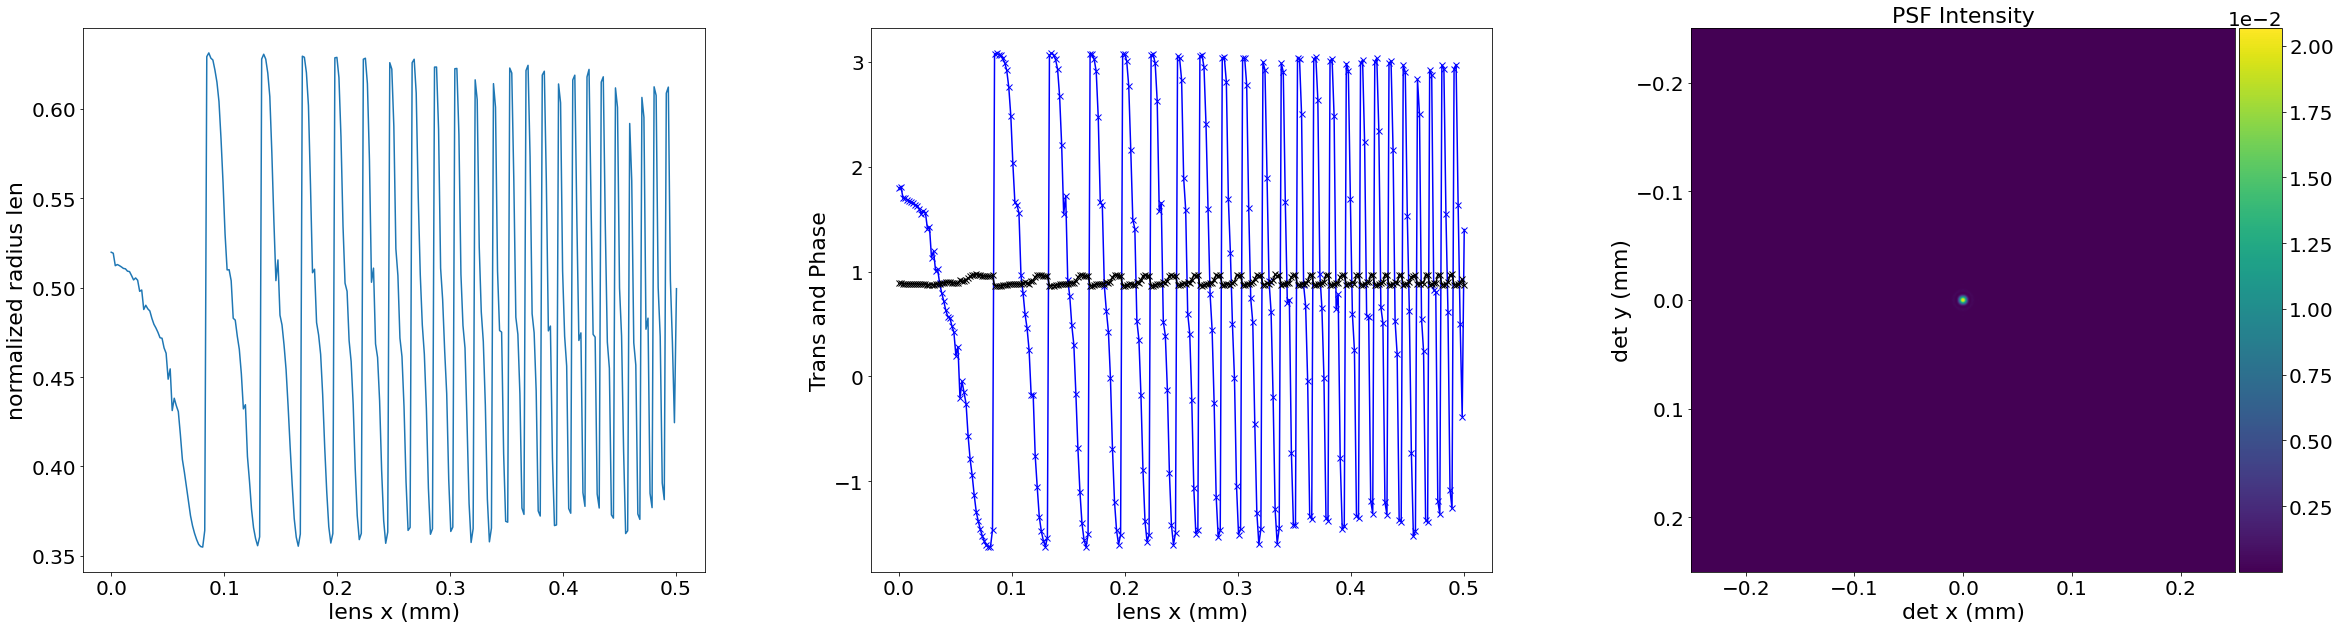

In [28]:
optimize_metalens_mlp(radial_symmetry=True, num_epochs=30, try_gpu=True)

Now run without radial symmetry Flag. The 2D metasurface will be assembled and 2D fields will be propagated instead. Cool, asymmetric PSFs can in theory be discovered like this but the memory costs are higher!


Checking for model checkpoint at: /content/DFlat/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense64_U180_H600/

 Model Checkpoint Loaded 

Checking for model checkpoint at: examples/output/metalens_example_radialFalse/

 Model Checkpoint Loaded 

Training Log | (Step, time, loss):  0 0.5932996273040771 -0.0001446453989925107
Training Log | (Step, time, loss):  1 0.5273013114929199 -0.00016125983541789526
Training Log | (Step, time, loss):  2 0.5251114368438721 -0.00018635177506381051
Training Log | (Step, time, loss):  3 0.5256891250610352 -0.00021895587322155036
Training Log | (Step, time, loss):  4 0.5296556949615479 -0.00025902571746556924
Training Log | (Step, time, loss):  5 0.528282880783081 -0.00030814449433981203
Log Training at step: 5

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  6 0.6472105979919434 -0.0003663561116843053
Training Log | (Step, time, loss):  7 0.5255413055419922 -0.0004356995480139772
Training Log | (Step, time, loss):  8 0.5255844593048096 -0.0005175606222903312
Training Log | (Step, time, loss):  9 0.5289533138275146 -0.0006137874202447445
Training Log | (Step, time, loss):  10 0.5277614593505859 -0.0007261665236534281
Log Training at step: 10

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  11 0.6636114120483398 -0.0008556618497116477
Training Log | (Step, time, loss):  12 0.5273675918579102 -0.0010036822940024436
Training Log | (Step, time, loss):  13 0.5279381275177002 -0.0011721848329050496
Training Log | (Step, time, loss):  14 0.5265541076660156 -0.001361215354945616

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  16 0.6777656078338623 -0.001806512370061345
Training Log | (Step, time, loss):  17 0.5273325443267822 -0.002068025356556161
Training Log | (Step, time, loss):  18 0.5265138149261475 -0.0023489017586287497
Training Log | (Step, time, loss):  19 0.5266735553741455 -0.0026346421275230715
Training Log | (Step, time, loss):  20 0.5269980430603027 -0.0029273052138842335
Log Training at step: 20

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  21 0.6521868705749512 -0.003232680467459346
Training Log | (Step, time, loss):  22 0.5264627933502197 -0.003550806467198801
Training Log | (Step, time, loss):  23 0.5266585350036621 -0.0038514522587030533
Training Log | (Step, time, loss):  24 0.5270304679870605 -0.004165557486490661
Training Log | (Step, time, loss):  25 0.5268239974975586 -0.004564009842192734
Log Training at step: 25

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  26 0.6398766040802002 -0.005008462001204856
Training Log | (Step, time, loss):  27 0.5312180519104004 -0.005491013381321498
Training Log | (Step, time, loss):  28 0.5302290916442871 -0.006016247550499173
Training Log | (Step, time, loss):  29 0.5300130844116211 -0.006588592676153089

 Model Saved Succesfully 



/content/DFlat/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


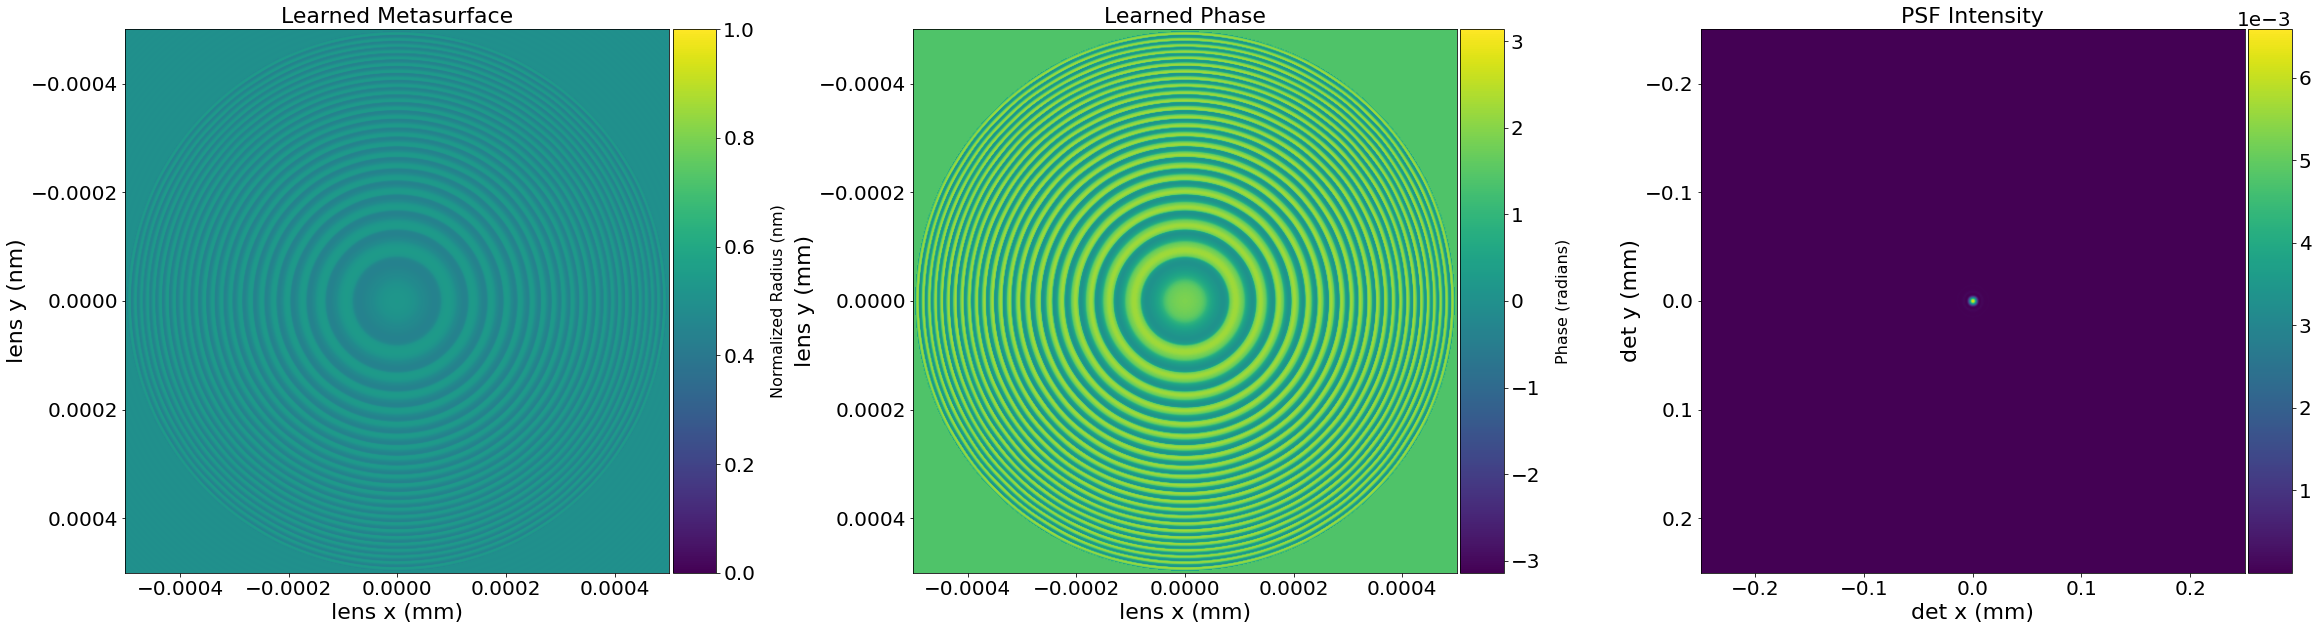

In [30]:
optimize_metalens_mlp(radial_symmetry=False, num_epochs=30, try_gpu=True)